In [19]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os


# Example usage: load a .mat file
# Provide the path to your .mat data file



In [20]:
u_CT = scipy.io.loadmat('CT_u_9.mat')["u"]
y_CT = scipy.io.loadmat('CT_x_9.mat')["y"]


u_T2D2 = scipy.io.loadmat('T2D2_u_9.mat')["u"]
y_T2D2 = scipy.io.loadmat('T2D2_x_9.mat')["y"]




In [21]:
u_T2D2.shape

(240, 3)

In [22]:
u_sp_CT = scipy.io.loadmat('CT_u_sp_7.mat')["u_sp"]
y_sp_CT = scipy.io.loadmat('CT_y_sp_7.mat')["y_sp"]


u_sp_T2D2 = scipy.io.loadmat('T2D2_u_sp_7.mat')["u_sp"]
y_sp_T2D2 = scipy.io.loadmat('T2D2_y_sp_7.mat')["y_sp"]


In [23]:
sum(u_CT[:,2])

np.float64(5897.954540079961)

In [24]:
sum(u_T2D2[:,2])

np.float64(5833.780348437762)

CT tracking cost:     149.848
CT input change cost: 13.663
CT total cost:        163.511
T2D2 tracking cost:     178.649
T2D2 input change cost: 31.525
T2D2 total cost:        210.174


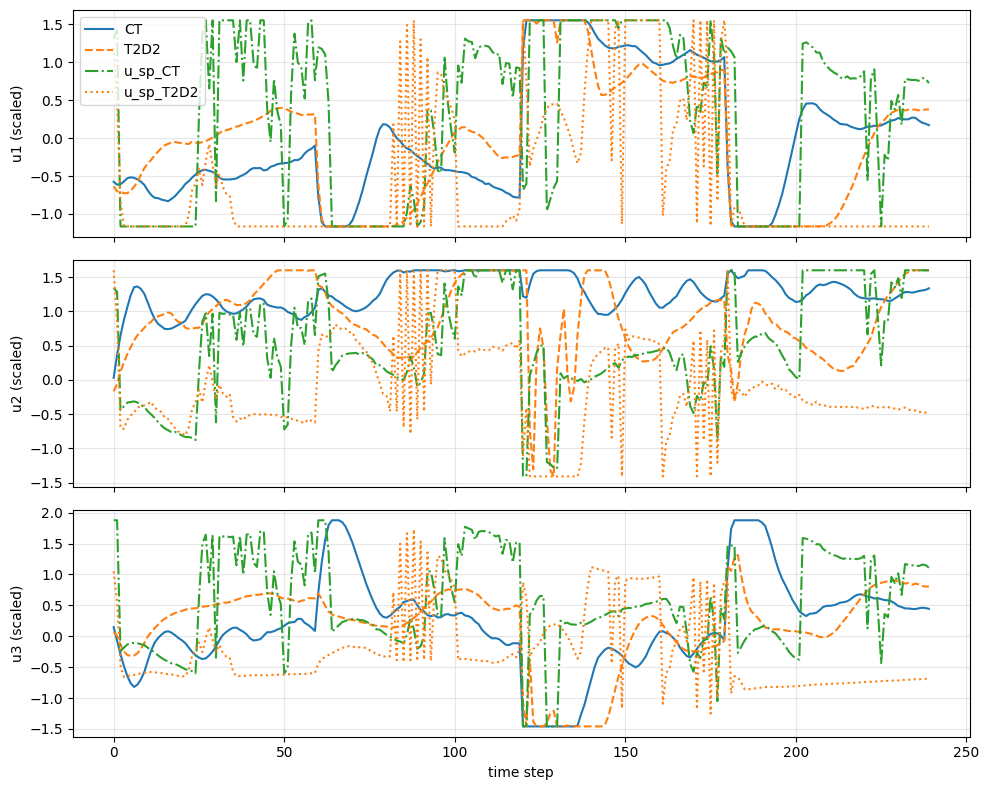

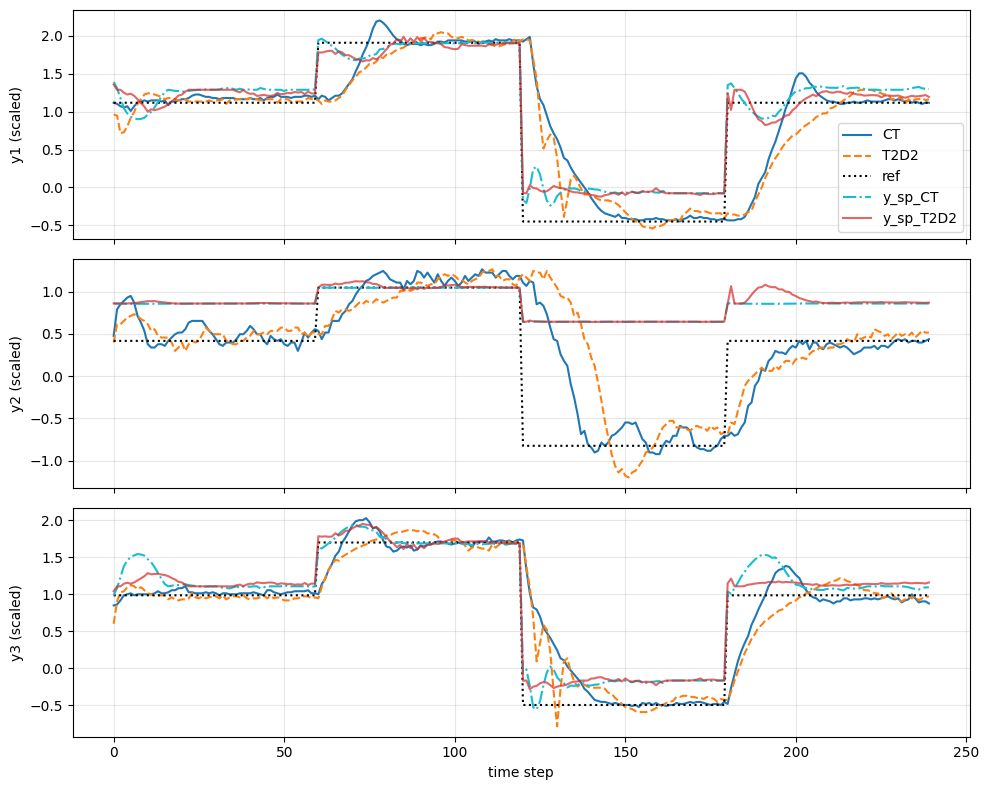

In [25]:
# Load MPC setup (scaled references, weights, etc.)
sim_setup = joblib.load(os.path.join('..', 'sim_setup.pkl'))
ref_scaled = sim_setup['reference']  # shape (ny, sim_time)
Qy = sim_setup['Qy']
Qu = sim_setup['Qu']

# Also load scalers explicitly in case data here is non-scaled
scaler = joblib.load(os.path.join('..', '..', 'data', 'scaler.pkl'))
scalerU = joblib.load(os.path.join('..', '..', 'data', 'scalerU.pkl'))

def to_time_first(arr):
    """Return array as shape (T, 3) assuming 3-dimensional signals."""
    a = np.squeeze(arr)
    if a.ndim == 1:
        a = a[:, None]
    # If first dimension is 3 and second isn't, assume (3, T) and transpose
    if a.shape[0] == 3 and (a.shape[1] != 3 or a.shape[0] <= a.shape[1]):
        a = a.T
    return a

# Put signals into (T, 3)
u_CT_t = to_time_first(u_CT)
y_CT_t = to_time_first(y_CT)

u_T2D2_t = to_time_first(u_T2D2)
y_T2D2_t = to_time_first(y_T2D2)

# Also put setpoints into (T, 3), using "sp" variables loaded elsewhere in notebook
u_sp_CT_t = to_time_first(u_sp_CT)
y_sp_CT_t = to_time_first(y_sp_CT)

u_sp_T2D2_t = to_time_first(u_sp_T2D2)
y_sp_T2D2_t = to_time_first(y_sp_T2D2)

# Scale data (if already scaled this is a no-op modulo affine transform consistent with setup)
u_CT_scaled = scalerU.transform(u_CT_t)
y_CT_scaled = scaler.transform(y_CT_t)

u_T2D2_scaled = scalerU.transform(u_T2D2_t)
y_T2D2_scaled = scaler.transform(y_T2D2_t)

u_sp_CT_scaled = scalerU.transform(u_sp_CT_t)
y_sp_CT_scaled = scaler.transform(y_sp_CT_t)

u_sp_T2D2_scaled = scalerU.transform(u_sp_T2D2_t)
y_sp_T2D2_scaled = scaler.transform(y_sp_T2D2_t)

# Truncate to common simulation horizon with reference and setpoints
T_CT = min(y_CT_scaled.shape[0], ref_scaled.shape[1], y_sp_CT_scaled.shape[0])
T_T2D2 = min(y_T2D2_scaled.shape[0], ref_scaled.shape[1], y_sp_T2D2_scaled.shape[0])
T_spu_CT = min(u_sp_CT_scaled.shape[0], ref_scaled.shape[1])
T_spu_T2D2 = min(u_sp_T2D2_scaled.shape[0], ref_scaled.shape[1])

# Compute closed-loop cost on scaled data, separating tracking and input terms
J_CT_tracking = 0.0
J_CT_input = 0.0
for k in range(50, T_CT):
    e_y = y_CT_scaled[k] - ref_scaled[:, k]
    prev_u = u_CT_scaled[k -1 ] if k > 0 else u_CT_scaled[k]
    u_CT_diff = u_CT_scaled[k] - prev_u
    J_CT_tracking += e_y @ Qy @ e_y
    J_CT_input += u_CT_diff @ Qu @ u_CT_diff
J_CT_sum = J_CT_tracking + J_CT_input

J_T2D2_tracking = 0.0
J_T2D2_input = 0.0
for k in range(50, T_T2D2):
    e_y = y_T2D2_scaled[k] - ref_scaled[:, k]
    prev_u = u_T2D2_scaled[k -1 ] if k > 0 else u_T2D2_scaled[k]
    u_T2D2_diff = u_T2D2_scaled[k] - prev_u
    J_T2D2_tracking += e_y @ Qy @ e_y
    J_T2D2_input += u_T2D2_diff @ Qu @ u_T2D2_diff
J_T2D2_sum = J_T2D2_tracking + J_T2D2_input

print(f"CT tracking cost:     {J_CT_tracking:.3f}")
print(f"CT input change cost: {J_CT_input:.3f}")
print(f"CT total cost:        {J_CT_sum:.3f}")

print(f"T2D2 tracking cost:     {J_T2D2_tracking:.3f}")
print(f"T2D2 input change cost: {J_T2D2_input:.3f}")
print(f"T2D2 total cost:        {J_T2D2_sum:.3f}")

# Time vectors
t_CT = np.arange(u_CT_t.shape[0])
t_T2D2 = np.arange(u_T2D2_t.shape[0])
t_ref = np.arange(ref_scaled.shape[1])
t_spy_CT = np.arange(T_CT)
t_spy_T2D2 = np.arange(T_T2D2)
t_spu_CT = np.arange(T_spu_CT)
t_spu_T2D2 = np.arange(T_spu_T2D2)

# Plot inputs u (3 dimensions), with u_sp for both CT and T2D2
fig_u, axes_u = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    axes_u[i].plot(t_CT, u_CT_scaled[:, i], label='CT', linestyle='-')
    axes_u[i].plot(t_T2D2, u_T2D2_scaled[:, i], label='T2D2', linestyle='--')
    axes_u[i].plot(t_spu_CT, u_sp_CT_scaled[:T_spu_CT, i], label='u_sp_CT', linestyle='-.', color='tab:green')
    axes_u[i].plot(t_spu_T2D2, u_sp_T2D2_scaled[:T_spu_T2D2, i], label='u_sp_T2D2', linestyle=':', color='tab:orange')
    axes_u[i].set_ylabel(f'u{i+1} (scaled)')
    axes_u[i].grid(True, alpha=0.3)
axes_u[-1].set_xlabel('time step')
axes_u[0].legend(loc='best')
fig_u.tight_layout()

# Plot outputs y (3 dimensions) with references from setup and y_sp for both CT and T2D2
fig_y, axes_y = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    axes_y[i].plot(t_CT, y_CT_scaled[:, i], label='CT', linestyle='-')
    axes_y[i].plot(t_T2D2, y_T2D2_scaled[:, i], label='T2D2', linestyle='--')
    axes_y[i].plot(t_ref, ref_scaled[i, :], label='ref', linestyle=':', color='k')
    axes_y[i].plot(t_spy_CT, y_sp_CT_scaled[:T_CT, i], label='y_sp_CT', linestyle='-.', color='tab:cyan')
    axes_y[i].plot(t_spy_T2D2, y_sp_T2D2_scaled[:T_T2D2, i], label='y_sp_T2D2', linestyle='-', color='tab:red', alpha=0.7)
    axes_y[i].set_ylabel(f'y{i+1} (scaled)')
    axes_y[i].grid(True, alpha=0.3)
axes_y[-1].set_xlabel('time step')
axes_y[0].legend(loc='best')
fig_y.tight_layout()


In [26]:
np.sum(np.square(y_T2D2_scaled - ref_scaled.T))

np.float64(180.47991514493498)

In [27]:
np.sum(np.square(y_CT_scaled - ref_scaled.T))

np.float64(152.08290018871736)